## Import Library

In [32]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from imblearn.over_sampling import SMOTE 

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, f1_score, roc_auc_score

from imblearn import under_sampling, over_sampling

## Load Dataset

In [33]:
df = pd.read_csv('/content/sample_data/in-vehicle-coupon-recommendation.csv')
df.head(5)

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


## Data Preprocessing

### Duplicated

In [34]:
df.duplicated().sum()

74

In [35]:
print(f"Data Frame Dimension Before Duplicate Removal: {df.shape}")
df = df.drop_duplicates()
print(f"Data Frame Dimension After Duplicate Removal: {df.shape}")

Data Frame Dimension Before Duplicate Removal: (12684, 26)
Data Frame Dimension After Duplicate Removal: (12610, 26)


### Missing Value

#### Numerical

In [36]:
df_numerical = df.select_dtypes(include=["int","float"]) #Mengambil kolom yang sifatnya data numerik
df_numerical.head()

,temperature,has_children,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,55,1,1,0,0,0,1,1
1,80,1,1,0,0,0,1,0
2,80,1,1,1,0,0,1,1
3,80,1,1,1,0,0,1,0
4,80,1,1,1,0,0,1,0


In [37]:
df_numerical.isnull().sum()

temperature          0
has_children         0
toCoupon_GEQ5min     0
toCoupon_GEQ15min    0
toCoupon_GEQ25min    0
direction_same       0
direction_opp        0
Y                    0
dtype: int64

In [38]:
print(f"Data Frame Numerical: {df_numerical.shape}")

Data Frame Numerical: (12610, 8)


#### Categorical

In [39]:
df_categorical = df.select_dtypes(exclude=["int","float"])
df_categorical.head()

,destination,passanger,weather,time,coupon,expiration,gender,age,maritalStatus,education,occupation,income,car,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50
0,No Urgent Place,Alone,Sunny,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3
1,No Urgent Place,Friend(s),Sunny,10AM,Coffee House,2h,Female,21,Unmarried partner,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3
2,No Urgent Place,Friend(s),Sunny,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3
3,No Urgent Place,Friend(s),Sunny,2PM,Coffee House,2h,Female,21,Unmarried partner,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3
4,No Urgent Place,Friend(s),Sunny,2PM,Coffee House,1d,Female,21,Unmarried partner,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3


In [40]:
df_categorical.isnull().sum()

destination                 0
passanger                   0
weather                     0
time                        0
coupon                      0
expiration                  0
gender                      0
age                         0
maritalStatus               0
education                   0
occupation                  0
income                      0
car                     12502
Bar                       107
CoffeeHouse               217
CarryAway                 150
RestaurantLessThan20      129
Restaurant20To50          189
dtype: int64

In [41]:
# Missing Value Information in Percentage
(100.00 * df_categorical.isnull().sum()) / df.shape[0]

destination              0.000000
passanger                0.000000
weather                  0.000000
time                     0.000000
coupon                   0.000000
expiration               0.000000
gender                   0.000000
age                      0.000000
maritalStatus            0.000000
education                0.000000
occupation               0.000000
income                   0.000000
car                     99.143537
Bar                      0.848533
CoffeeHouse              1.720856
CarryAway                1.189532
RestaurantLessThan20     1.022998
Restaurant20To50         1.498810
dtype: float64

It is recommended to remove feature whose missing value number > 50%

In [42]:
# Remove car
print(f"Data Frame Dimension Before Duplicate Removal: {df_categorical.shape}")
df_categorical = df_categorical.drop(["car"],axis = 1)
print(f"Data Frame Dimension After Duplicate Removal: {df_categorical.shape}")

Data Frame Dimension Before Duplicate Removal: (12610, 18)
Data Frame Dimension After Duplicate Removal: (12610, 17)


In [43]:
# Find out the "mode" from categorical feature using value_counts()
print(df_categorical["Bar"].value_counts())
print(df_categorical["CoffeeHouse"].value_counts())
print(df_categorical["CarryAway"].value_counts())
print(df_categorical["RestaurantLessThan20"].value_counts())
print(df_categorical["Restaurant20To50"].value_counts())

never    5178
less1    3438
1~3      2468
4~8      1071
gt8       348
Name: Bar, dtype: int64
less1    3362
1~3      3199
never    2946
4~8      1779
gt8      1107
Name: CoffeeHouse, dtype: int64
1~3      4645
4~8      4242
less1    1849
gt8      1572
never     152
Name: CarryAway, dtype: int64
1~3      5356
4~8      3553
less1    2071
gt8      1282
never     219
Name: RestaurantLessThan20, dtype: int64
less1    6041
1~3      3266
never    2122
4~8       728
gt8       264
Name: Restaurant20To50, dtype: int64


In [44]:
import statistics

# Mode
df_categorical["Bar"] = df_categorical["Bar"].fillna(statistics.mode(df_categorical["Bar"]))
df_categorical["CoffeeHouse"] = df_categorical["CoffeeHouse"].fillna(statistics.mode(df_categorical["CoffeeHouse"]))
df_categorical["CarryAway"] = df_categorical["CarryAway"].fillna(statistics.mode(df_categorical["CarryAway"]))
df_categorical["RestaurantLessThan20"] = df_categorical["RestaurantLessThan20"].fillna(statistics.mode(df_categorical["RestaurantLessThan20"]))
df_categorical["Restaurant20To50"] = df_categorical["Restaurant20To50"].fillna(statistics.mode(df_categorical["Restaurant20To50"]))

# Missing Value Recount
df_categorical.isnull().sum()

destination             0
passanger               0
weather                 0
time                    0
coupon                  0
expiration              0
gender                  0
age                     0
maritalStatus           0
education               0
occupation              0
income                  0
Bar                     0
CoffeeHouse             0
CarryAway               0
RestaurantLessThan20    0
Restaurant20To50        0
dtype: int64

In [45]:
print(f"Data Frame Categorical: {df_categorical.shape}")

Data Frame Categorical: (12610, 17)


### Outlier Handling

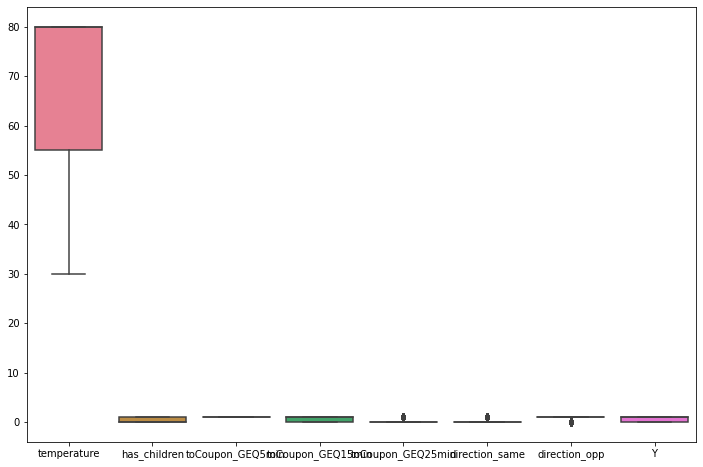

In [46]:
# Use Boxplot
df_numerical = df.select_dtypes(include = ["int64","float64"])

# Figure Size Setting
plt.figure(figsize=(12,8))

# Boxplot using Seaborn
sns.boxplot(data=df_numerical,
            palette="husl")

# Show the plot
plt.show()

### Multicolinearity Handling

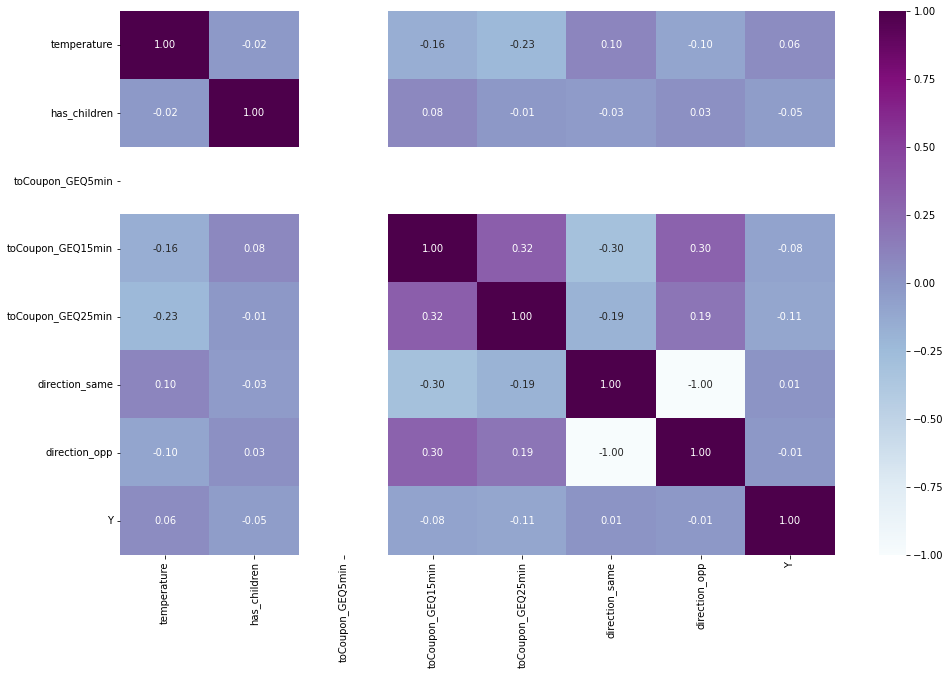

In [47]:
corr_= df_numerical.corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr_, annot=True, fmt = ".2f", cmap = "BuPu")

In [48]:
# Choose one between direction_same and direction_opp

df_numerical = df_numerical.drop(["direction_opp"],axis = 1)

### Processing Categorical Variable

In [49]:
df_categorical.head()

,destination,passanger,weather,time,coupon,expiration,gender,age,maritalStatus,education,occupation,income,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50
0,No Urgent Place,Alone,Sunny,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,Some college - no degree,Unemployed,$37500 - $49999,never,never,1~3,4~8,1~3
1,No Urgent Place,Friend(s),Sunny,10AM,Coffee House,2h,Female,21,Unmarried partner,Some college - no degree,Unemployed,$37500 - $49999,never,never,1~3,4~8,1~3
2,No Urgent Place,Friend(s),Sunny,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,Some college - no degree,Unemployed,$37500 - $49999,never,never,1~3,4~8,1~3
3,No Urgent Place,Friend(s),Sunny,2PM,Coffee House,2h,Female,21,Unmarried partner,Some college - no degree,Unemployed,$37500 - $49999,never,never,1~3,4~8,1~3
4,No Urgent Place,Friend(s),Sunny,2PM,Coffee House,1d,Female,21,Unmarried partner,Some college - no degree,Unemployed,$37500 - $49999,never,never,1~3,4~8,1~3


1. One-hot Encoding (Binary, 1 / 0)
    - Use when unique value < 5
2. Ordinal Encoding (Grade, 1 < 2 < 3 < ... < n)
    - The method itself can be applied to categorical data type (nominal, ordinal)
3. Frequency Encoding (Based on its appearance)
    - Use when unique value >= 5



#### One Hot Encoding

In [50]:
# 1. One-hot Encoding applied for nominal data scale

df_categorical["destination"].value_counts().reset_index()
df_categorical["passanger"].value_counts().reset_index()
df_categorical["weather"].value_counts().reset_index()
df_categorical["coupon"].value_counts().reset_index()
df_categorical["maritalStatus"].value_counts().reset_index()

,index,maritalStatus
0,Married partner,5068
1,Single,4716
2,Unmarried partner,2185
3,Divorced,511
4,Widowed,130


#### Ordinal Encoding

In [51]:
# 2. Ordinal Encoding applied for ordinal data scale 

print(df_categorical["time"].value_counts().reset_index())
print(df_categorical["expiration"].value_counts().reset_index())
print(df_categorical["gender"].value_counts().reset_index())
print(df_categorical["age"].value_counts().reset_index())
print(df_categorical["education"].value_counts().reset_index())
print(df_categorical["income"].value_counts().reset_index())
print(df_categorical["Bar"].value_counts().reset_index())
print(df_categorical["CoffeeHouse"].value_counts().reset_index())
print(df_categorical["CarryAway"].value_counts().reset_index())
print(df_categorical["RestaurantLessThan20"].value_counts().reset_index())
print(df_categorical["Restaurant20To50"].value_counts().reset_index())

  index  time
0   6PM  3220
1   7AM  3114
2  10AM  2271
3   2PM  2006
4  10PM  1999
  index  expiration
0    1d        7031
1    2h        5579
    index  gender
0  Female    6469
1    Male    6141
     index   age
0       21  2642
1       26  2548
2       31  2019
3   50plus  1781
4       36  1317
5       41  1089
6       46   670
7  below21   544
                                    index  education
0                Some college - no degree       4325
1                        Bachelors degree       4323
2  Graduate degree (Masters or Doctorate)       1827
3                       Associates degree       1148
4                    High School Graduate        899
5                        Some High School         88
              index  income
0   $25000 - $37499    2006
1   $12500 - $24999    1825
2   $37500 - $49999    1795
3   $100000 or More    1717
4   $50000 - $62499    1655
5  Less than $12500    1034
6   $87500 - $99999     879
7   $75000 - $87499     856
8   $62500 - $74999     84

In [52]:
# Use .map(class) to replace value by value using dictionary

time_class = {"7AM": 0, "10AM": 1, "2PM": 2, "6PM": 3, "10PM": 4}
exp_class = {"2h": 0, "1d": 1}
gender_class = {"Female": 0, "Male": 1}
age_class = {"below21": 0, "21": 1, "26": 2, "31": 3, "36": 4, "41": 5, "46": 6, "50plus": 7}
edu_class = {"Some High School": 0, "High School Graduate": 1, "Some college - no degree": 2, 
             "Associates degree": 3, "Bachelors degree": 4, "Graduate degree (Masters or Doctorate)": 5}
income_class = {"Less than $12500": 0, "$12500 - $24999": 1, "$25000 - $37499": 2, "$37500 - $49999": 3, 
                "$50000 - $62499": 4, "$62500 - $74999": 5, "$75000 - $87499": 6, "$87500 - $99999": 7, 
                "$100000 or More": 8}
Bar_class = {"never": 0, "less1": 1, "1~3": 2, "4~8": 3, "gt8": 4}
CoffeeHouse_class = {"never": 0, "less1": 1, "1~3": 2, "4~8": 3, "gt8": 4}
CarryAway_class = {"never": 0, "less1": 1, "1~3": 2, "4~8": 3, "gt8": 4}
RestaurantLessThan20_class = {"never": 0, "less1": 1, "1~3": 2, "4~8": 3, "gt8": 4}
Restaurant20To50_class = {"never": 0, "less1": 1, "1~3": 2, "4~8": 3, "gt8": 4}

df_categorical["time"] = df_categorical["time"].map(time_class)
df_categorical["expiration"] = df_categorical["expiration"].map(exp_class)
df_categorical["gender"] = df_categorical["gender"].map(gender_class)
df_categorical["age"] = df_categorical["age"].map(age_class)
df_categorical["education"] = df_categorical["education"].map(edu_class)
df_categorical["income"] = df_categorical["income"].map(income_class)
df_categorical["Bar"] = df_categorical["Bar"].map(Bar_class)
df_categorical["CoffeeHouse"] = df_categorical["CoffeeHouse"].map(CoffeeHouse_class)
df_categorical["CarryAway"] = df_categorical["CarryAway"].map(CarryAway_class)
df_categorical["RestaurantLessThan20"] = df_categorical["RestaurantLessThan20"].map(RestaurantLessThan20_class)
df_categorical["Restaurant20To50"] = df_categorical["Restaurant20To50"].map(Restaurant20To50_class)

df_categorical.iloc[19]

destination                              Work
passanger                               Alone
weather                                 Sunny
time                                        0
coupon                  Carry out & Take away
expiration                                  0
gender                                      0
age                                         1
maritalStatus               Unmarried partner
education                                   2
occupation                         Unemployed
income                                      3
Bar                                         0
CoffeeHouse                                 0
CarryAway                                   2
RestaurantLessThan20                        3
Restaurant20To50                            2
Name: 19, dtype: object

#### Frequency Encoding

In [53]:
# 3. Frequency Encoding (Based on its appearance)

freq = df_categorical["occupation"].value_counts().reset_index()
freq.rename(columns={"index": "occupation", "occupation": "freq_occupation"}, inplace = True)
freq['pct_occupation'] = round((freq['freq_occupation']/freq['freq_occupation'].sum())*100,2)
freq

,occupation,freq_occupation,pct_occupation
0,Unemployed,1861,14.76
1,Student,1575,12.49
2,Computer & Mathematical,1390,11.02
3,Sales & Related,1088,8.63
4,Education&Training&Library,939,7.45
5,Management,821,6.51
6,Office & Administrative Support,638,5.06
7,Arts Design Entertainment Sports & Media,627,4.97
8,Business & Financial,543,4.31
9,Retired,493,3.91


In [54]:
df_categorical = df_categorical.merge(freq[['occupation','pct_occupation']], on = 'occupation', how = 'inner')
df_categorical = df_categorical.drop(["occupation"],axis = 1)

df_categorical.iloc[19]

destination                              Work
passanger                               Alone
weather                                 Sunny
time                                        0
coupon                  Carry out & Take away
expiration                                  0
gender                                      0
age                                         1
maritalStatus               Unmarried partner
education                                   2
income                                      3
Bar                                         0
CoffeeHouse                                 0
CarryAway                                   2
RestaurantLessThan20                        3
Restaurant20To50                            2
pct_occupation                          14.76
Name: 19, dtype: object

In [55]:
# Use pd.get_dummies(data frame) to apply one-hot encoding
df_categorical_encoded = pd.get_dummies(df_categorical,columns = ["destination","passanger","weather","coupon","maritalStatus"])
df_categorical_encoded.iloc[19]

time                                0.00
expiration                          0.00
gender                              0.00
age                                 1.00
education                           2.00
income                              3.00
Bar                                 0.00
CoffeeHouse                         0.00
CarryAway                           2.00
RestaurantLessThan20                3.00
Restaurant20To50                    2.00
pct_occupation                     14.76
destination_Home                    0.00
destination_No Urgent Place         0.00
destination_Work                    1.00
passanger_Alone                     1.00
passanger_Friend(s)                 0.00
passanger_Kid(s)                    0.00
passanger_Partner                   0.00
weather_Rainy                       0.00
weather_Snowy                       0.00
weather_Sunny                       1.00
coupon_Bar                          0.00
coupon_Carry out & Take away        1.00
coupon_Coffee Ho

In [56]:
print(f"Data Frame Categorical Encoded: {df_categorical_encoded.shape}")
print(f"Data Frame Numerical: {df_numerical.shape}")

Data Frame Categorical Encoded: (12610, 32)
Data Frame Numerical: (12610, 7)


In [57]:
# Finalize (combine both numerical and categorical data frame using concat)
# Concat axis 1 --> Column
# Concat axis 0 --> Row
df = pd.concat([df_categorical_encoded,df_numerical],axis=1)
df = df.dropna()
df.iloc[19]

time                                0.00
expiration                          0.00
gender                              0.00
age                                 1.00
education                           2.00
income                              3.00
Bar                                 0.00
CoffeeHouse                         0.00
CarryAway                           2.00
RestaurantLessThan20                3.00
Restaurant20To50                    2.00
pct_occupation                     14.76
destination_Home                    0.00
destination_No Urgent Place         0.00
destination_Work                    1.00
passanger_Alone                     1.00
passanger_Friend(s)                 0.00
passanger_Kid(s)                    0.00
passanger_Partner                   0.00
weather_Rainy                       0.00
weather_Snowy                       0.00
weather_Sunny                       1.00
coupon_Bar                          0.00
coupon_Carry out & Take away        1.00
coupon_Coffee Ho

In [58]:
print(f"Data Frame: {df.shape}")

Data Frame: (12536, 39)


## Imbalance Data Handling

In [59]:
df['Y'].value_counts()

1.0    7126
0.0    5410
Name: Y, dtype: int64

In [60]:
sm = over_sampling.SMOTE(random_state=42)

X = df.drop(['Y'],axis = 1)
Y = df['Y']
X_sm, y_sm = sm.fit_resample(X, Y)

print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100

Shape of X before SMOTE: (12536, 38)
Shape of X after SMOTE: (14252, 38)

Balance of positive and negative classes (%):


1.0    50.0
0.0    50.0
Name: Y, dtype: float64

In [61]:
y_sm.value_counts()

1.0    7126
0.0    7126
Name: Y, dtype: int64

## Modeling 

### Split Dataset

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.25, random_state=42)

### Random Forest Modeling

In [63]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)

## Evaluation

In [65]:
print('Accuracy',accuracy_score(y_test, preds))

Accuracy 0.6595565534661801
